<a href="https://colab.research.google.com/github/Gustavo-br-rj/PROJ-BI_MASTER/blob/main/4_PREVER_TEMP_MANCAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Previsão de Série Temporal da Temperatura de Mancais Utilizando LSTM


## Parte 0 - Importação das Bibliotecas

In [101]:
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import json

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#tf.__version__

## Parte 1 - Importação do Dataset e Predição dos Valores de Temperatura dos Mancais

In [103]:
# Importação da Base de Dados
dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/DATASETS/dataset_C-4451_08001A.csv')

In [104]:
#Conversão do campo data para datetime e ordenação do dataset
dataset['DATA'] = pd.to_datetime(dataset['DATA'],dayfirst=True)
dataset = dataset.sort_values(['EQUIPAMENTO', 'MANCAL', 'DATA'], ascending=[1, 1, 1])

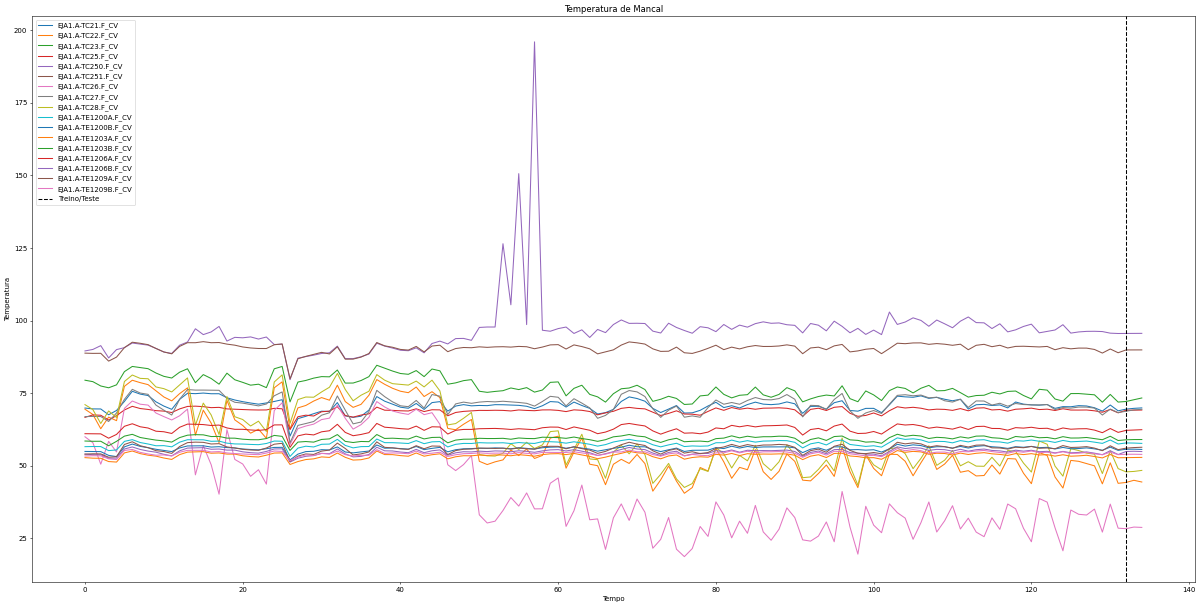

In [106]:
#Diretório dos modelos de RN para cada mancal
dirModel = '/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/MODELOS/'

#Buscando a identificação dos mancais
mancais = dataset['MANCAL'].unique().tolist()

plt.figure(figsize=(30, 15), dpi=50)

for i in range(len(mancais)):
  manc = dataset.loc[(dataset["MANCAL"] == mancais[i]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
  manc = manc.reset_index(drop=True)

  nomeModelo  = '{0}{1}__{2}_model'.format(dirModel,manc['EQUIPAMENTO'].to_numpy()[0], manc['MANCAL'].to_numpy()[0])
  paramModelo = '{0}{1}__{2}_params.json'.format(dirModel,manc['EQUIPAMENTO'].to_numpy()[0], manc['MANCAL'].to_numpy()[0])

  #Obtendo o arquivo de parâmetros
  f_json = open(paramModelo,)
  json_param = json.load(f_json)
  f_json.close()

  #Reconstruindo o modelo
  reconstructed_model = load_model(nomeModelo)

  #Pegando a última janela de dados do conjunto
  window = json_param["window"]
  last_window_set = manc.tail(window)
  last_window_set = last_window_set.iloc[0:window, 3:4].values

  #Normalizando
  sc = MinMaxScaler(feature_range = (0, 1))
  last_window_set_scaled = sc.fit_transform(last_window_set)

  #Prever temperatura
  output = json_param["output"]
  X_last_window = [] 
  X_last_window.append(last_window_set_scaled[0:window, 0])
  X_last_window = np.array(X_last_window)
  X_last_window = np.reshape(X_last_window, (X_last_window.shape[0], X_last_window.shape[1], 1))

  predicted = reconstructed_model.predict(X_last_window)
  predicted = sc.inverse_transform(predicted)

  all_entries = manc.iloc[:,3:4].values
  results = predicted[0]
  
  temps = all_entries
  temps = np.insert(temps,len(temps),results)
  
  plt.plot(temps,  label=mancais[i])


plt.axvline(x=len(all_entries), label='Previsão', c='k',ls='--')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.legend()
plt.show()

## Parte 2 - Verificação das premissas